In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
train_data=pd.read_csv("/kaggle/input/text-dataset/training.csv")
test_data=pd.read_csv("/kaggle/input/text-dataset/test.csv")
val_data=pd.read_csv("/kaggle/input/text-dataset/validation.csv")

In [8]:
train_data.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
from collections import Counter 
Counter(train_data['label'])

Counter({1: 5362, 0: 4666, 3: 2159, 4: 1937, 2: 1304, 5: 572})

In [10]:
index = train_data[train_data.duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
index = train_data[train_data['text'].duplicated() == True].index
train_data.drop(index, axis = 0, inplace = True)
train_data.reset_index(inplace=True, drop = True)
train_data.shape

(15969, 2)

In [11]:
def lemmatization(text):
    doc = nlp(text)
    return " ".join([token.lemma_ for token in doc])

def remove_stop_words(text):

    Text=[i for i in str(text).split() if i not in stop_words]
    return " ".join(Text)

def Removing_numbers(text):
    text=''.join([i for i in text if not i.isdigit()])
    return text

def lower_case(text):
    
    text = text.split()

    text=[y.lower() for y in text]
    
    return " " .join(text)

def Removing_punctuations(text):
    ## Remove punctuations
    text = re.sub('[%s]' % re.escape("""!"#$%&'()*+,،-./:;<=>؟?@[\]^_`{|}~"""), ' ', text)
    text = text.replace('؛',"", )
    
    ## remove extra whitespace
    text = re.sub('\s+', ' ', text)
    text =  " ".join(text.split())
    return text.strip()

def Removing_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_small_sentences(df):
    for i in range(len(df)):
        if len(df.text.iloc[i].split()) < 3:
            df.text.iloc[i] = np.nan
            
def normalize_text(df):
    tqdm.pandas()
    df.text=df.text.progress_apply(lambda text : lower_case(text))
    df.text=df.text.progress_apply(lambda text : remove_stop_words(text))
    df.text=df.text.progress_apply(lambda text : Removing_numbers(text))
    df.text=df.text.progress_apply(lambda text : Removing_punctuations(text))
    df.text=df.text.progress_apply(lambda text : Removing_urls(text))
    df.text=df.text.progress_apply(lambda text : lemmatization(text))
    return df

def normalized_sentence(sentence):
    sentence= lower_case(sentence)
    sentence= remove_stop_words(sentence)
    sentence= Removing_numbers(sentence)
    sentence= Removing_punctuations(sentence)
    sentence= Removing_urls(sentence)
    sentence= lemmatization(sentence)
    return sentence

In [12]:
from nltk.corpus import stopwords
import re
from tqdm import tqdm
from nltk.stem import SnowballStemmer
import spacy
nlp = spacy.load("en_core_web_sm")
stop_words = set(stopwords.words("english"))


In [13]:
train_data= normalize_text(train_data)
test_data= normalize_text(test_data)
val_data= normalize_text(val_data)

100%|██████████| 2000/2000 [00:12<00:00, 161.08it/s]


In [14]:
X_train = train_data['text']
y_train = train_data['label']

X_test = test_data['text']
y_test = test_data['label']

X_val = val_data['text']
y_val = val_data['label']

In [15]:
from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(oov_token='UNK')
tokenizer.fit_on_texts(pd.concat([X_train, X_test], axis=0))

In [17]:
tokenizer.document_count

17969

In [ ]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)
sequences_val = tokenizer.texts_to_sequences(X_val)

In [55]:
maxlen = max([len(t) for t in train_data['text']])
maxlen

221

In [56]:
X_train = pad_sequences(sequences_train, maxlen=229, truncating='pre')
X_test = pad_sequences(sequences_test, maxlen=229, truncating='pre')
X_val = pad_sequences(sequences_val, maxlen=229, truncating='pre')

vocabSize = len(tokenizer.index_word) + 1
print(f"Vocabulary size = {vocabSize}")

Vocabulary size = 12931


In [58]:
path_to_glove_file = '/kaggle/input/glove-global-vectors-for-word-representation/glove.6B.200d.txt'
num_tokens = vocabSize
embedding_dim = 200 #latent factors or features  
hits = 0
misses = 0
embeddings_index = {}

In [61]:
with open(path_to_glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
print("Found %s word vectors." % len(embeddings_index))

# Assign word vectors to our dictionary/vocabulary
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        # This includes the representation for "padding" and "OOV"
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Found 400000 word vectors.
Converted 11799 words (1131 misses)


In [63]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional

In [74]:
callback = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
)

In [76]:
adam = Adam(learning_rate=0.005)

model = Sequential()
model.add(Embedding(vocabSize, 200, input_length=X_train.shape[1], weights=[embedding_matrix], trainable=False))
model.add(Bidirectional(LSTM(256, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2, return_sequences=True)))
model.add(Bidirectional(LSTM(128, dropout=0.2,recurrent_dropout=0.2)))
model.add(Dense(6, activation='softmax'))
model.build(input_shape=(None, X_train.shape[1]))
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)         │ (None, 229, 200)       │     2,586,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_12                │ (None, 229, 512)       │       935,936 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_13                │ (None, 229, 256)       │       656,384 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_14                │ (None, 256)            │       394,240 │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,574,302 (17.45 MB)

 Trainable params: 1,988,102 (7.58 MB)

 Non-trainable params: 2,586,200 (9.87 MB)

In [77]:
history = model.fit(X_train,
                    y_train,
                    validation_data=(X_val, y_val),
                    verbose=1,
                    batch_size=256,
                    epochs=30,
                    callbacks=[callback]
                   )

Epoch 1/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 103s 1s/step - accuracy: 0.4050 - loss: 1.5323 - val_accuracy: 0.6135 - val_loss: 1.0974
Epoch 2/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6358 - loss: 1.0281 - val_accuracy: 0.8135 - val_loss: 0.5276
Epoch 3/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - accuracy: 0.8267 - loss: 0.4879 - val_accuracy: 0.8785 - val_loss: 0.3482
Epoch 4/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.8887 - loss: 0.3145 - val_accuracy: 0.9005 - val_loss: 0.2509
Epoch 5/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9112 - loss: 0.2265 - val_accuracy: 0.9120 - val_loss: 0.2216
Epoch 6/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9312 - loss: 0.1691 - val_accuracy: 0.9185 - val_loss: 0.2101
Epoch 7/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 92s 1s/step - accuracy: 0.9360 - loss: 0.1461 - val_accuracy: 0.9190 - val_loss: 0.1881
Epoch 8/30
63/63 ━━━━━━━━━━━━━━━━━━━━ 93s 1s/step - accuracy: 0.9480 - loss: 0.1213 - val_accuracy: 0.9205 - val_loss

In [102]:
model.save("final_model.keras")

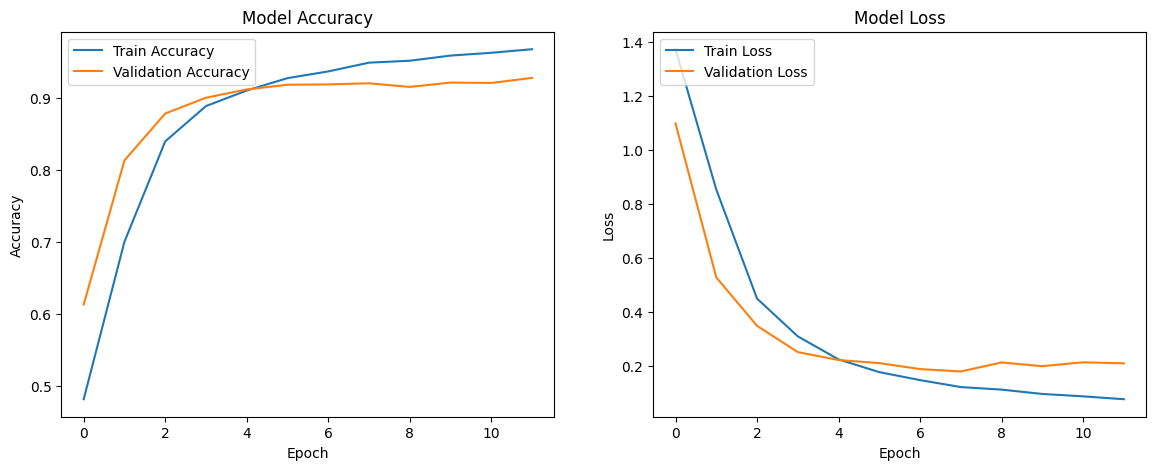

In [78]:
import matplotlib.pyplot as plt

# Assuming the model has been trained and the history object is available
# Function to plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(14, 5))
    
    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    
    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper left')
    
    # Show the plots
    plt.show()

# Call the function to plot the graphs
plot_training_history(history)


In [81]:
pred=np.argmax(model.predict(X_test),axis=1)

63/63 ━━━━━━━━━━━━━━━━━━━━ 21s 328ms/step


In [86]:
from sklearn.metrics import accuracy_score,classification_report
print("accuracy of model on test dataset is ",accuracy_score(pred,y_test))


accuracy of model on test dataset is  0.904


In [87]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

           0       0.95      0.94      0.94       588
           1       0.92      0.94      0.93       681
           2       0.81      0.76      0.78       170
           3       0.89      0.92      0.91       268
           4       0.88      0.86      0.87       228
           5       0.70      0.71      0.70        65

    accuracy                           0.90      2000
   macro avg       0.86      0.85      0.86      2000
weighted avg       0.90      0.90      0.90      2000



In [ ]:
sentences = [
            "He's over the moon about being accepted to the university",
            "Your point on this certain matter made me outrageous, how can you say so? This is insane.",
            "I can't do it, I'm not ready to lose anything, just leave me alone",
            "Merlin's beard harry, you can cast the Patronus charm! I'm amazed!",
            "i lost my friend",
            "Dogs are sitting by the door."
            ]
emotion_dict = {
    0: 'sadness',
    1: 'joy',
    2: 'love',
    3: 'anger',
    4: 'fear',
    5: 'surprise'
}
for sentence in sentences:
    print(sentence)
    sentence = normalized_sentence(sentence)
    sentence = tokenizer.texts_to_sequences([sentence])
    sentence = pad_sequences(sentence, maxlen=229, truncating='pre')
    result = np.argmax(model.predict(sentence), axis=1)
    print(f"{result} : {emotion_dict[result[0]]}\n\n")

In [95]:
!pip install sounddevice scipy whisper torch


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for whisper: filename=whisper-1.1.10-py3-none-any.whl size=41120 sha256=199327d5969a46912b67c0a41812b5e65f976ac596855058bbcdb8a0e16a075d
  Stored in directory: /root/.cache/pip/wheels/aa/7c/1d/015619716e2facae6631312503baf3c3220e6a9a3508cb14b6
Successfully built whisper


In [101]:
import whisper

# Path to the uploaded audio file in Kaggle

# Load the Whisper model
model = whisper.load_model("base")


AttributeError: module 'whisper' has no attribute 'load_model'

In [100]:
!pip install git+https://github.com/openai/whisper.git

  Cloning https://github.com/openai/whisper.git to /tmp/pip-req-build-0422cehj
  Running command git clone --filter=blob:none --quiet https://github.com/openai/whisper.git /tmp/pip-req-build-0422cehj
  Resolved https://github.com/openai/whisper.git to commit ba3f3cd54b0e5b8ce1ab3de13e32122d0d5f98ab
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [18]:
import json

# Serialize the tokenizer to JSON
tokenizer_json = tokenizer.to_json()

# Save the JSON to a file
with open('tokenizer.json', 'w') as f:
    f.write(tokenizer_json)

In [98]:
!pip install openai-whisper


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 798.6/798.6 kB 15.9 MB/s eta 0:00:0000:01
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.1/168.1 MB 9.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 47.4 MB/s eta 0:00:00
  Created wheel for openai-whisper: filename=openai_whisper-20231117-py3-none-any.whl size=801358 sha256=c2717b8a2fd425d4ad247b432fd545de73fa483f49402d0a28c9e4acc7daee07
  Stored in directory: /root/.cache/pip/wheels/d0/85/e1/9361b4cbea7dd4b7f6702fa4c3afc94877952eeb2b62f45f56
Successfully built openai-whisper
